In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# 加载数据

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print(f"训练集长度:{len(train_df)}, 测试集长度:{len(test_df)}")
# pd.set_option('display.max_columns', None)
# print(train_df.head())

训练集长度:1460, 测试集长度:1459


# 探索性数据分析 (EDA)

<Axes: xlabel='SalePrice', ylabel='Density'>

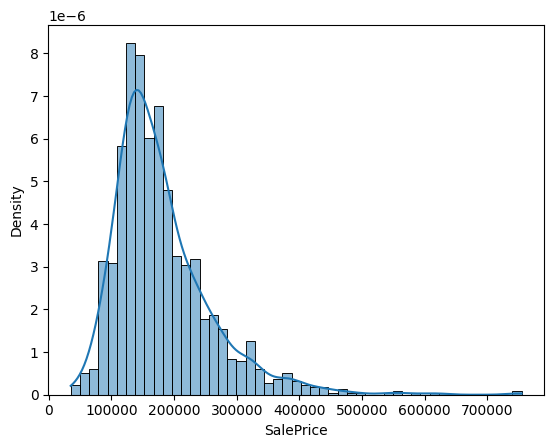

In [3]:
sns.histplot(train_df['SalePrice'], kde=True, stat="density") # 左偏分布，最右边为部分豪宅

<Axes: xlabel='SalePrice', ylabel='Count'>

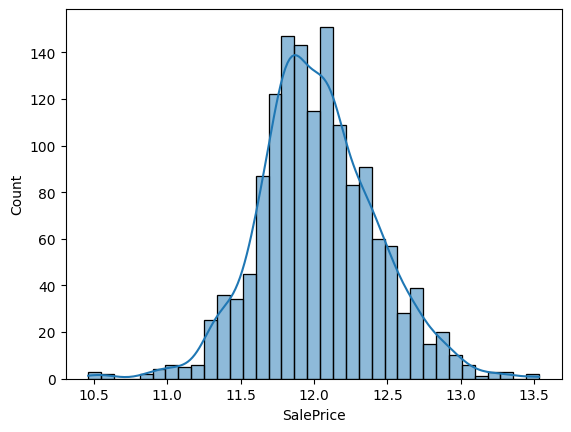

In [4]:
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])
# 转换后再检查一遍，你会发现它变得非常接近正态分布
sns.histplot(train_df['SalePrice'], kde=True)

# 数据清洗 (Data Cleaning)

In [5]:
## 查看缺失值：
# pd.set_option('display.max_rows', None)
# print(train_df.isnull().sum())
# print(test_df.isnull().sum())

## 缺失值处理

### 区域与设施

In [6]:
### 区域分类：MSZoning，测试集缺失4->众数插补
MSZoning_mode = train_df["MSZoning"].mode()[0]
test_df.loc[:,"MSZoning"] = test_df["MSZoning"].fillna(MSZoning_mode)

### 房子同街道之间的距离： LotFrontage 训练集缺失259，测试集缺失227-》中位数插补
LotFrontage_median_imputer = SimpleImputer(strategy='median')
train_df.loc[:, "LotFrontage"] = LotFrontage_median_imputer.fit_transform(train_df[["LotFrontage"]])
test_df.loc[:,"LotFrontage"] = LotFrontage_median_imputer.transform(test_df[["LotFrontage"]])

### 小道的路面类型 Alley 训练集缺失1369 测试集缺失1352, 缺失量过多, 用None表示
train_df.loc[:,"Alley"] = train_df["Alley"].fillna("None")
test_df.loc[:,"Alley"] = test_df["Alley"].fillna("None")

### 配套公用设施类型 Utilities 测试集缺失2->众数插补
Utilities_mode = train_df["Utilities"].mode()[0]
test_df.loc[:,"Utilities"] = test_df["Utilities"].fillna(Utilities_mode)

### 建材

In [7]:
### 外立面材料 Exterior1st 测试集缺失1->众数插补
Exterior1st_mode = train_df["Exterior1st"].mode()[0]
test_df.loc[:,"Exterior1st"] = test_df["Exterior1st"].fillna(Exterior1st_mode)

### 外立面材料2 Exterior2nd 测试集缺失1->众数插补
Exterior2nd_mode = train_df["Exterior2nd"].mode()[0]
test_df.loc[:,"Exterior2nd"] = test_df["Exterior2nd"].fillna(Exterior2nd_mode)

### 装饰石材类型 MasVnrType 训练集缺失872, 测试集缺失894-》众数插补？缺失的也很多
MasVnrType_mode = train_df["MasVnrType"].mode()[0]
train_df.loc[:,"MasVnrType"] = train_df["MasVnrType"].fillna(MasVnrType_mode)
test_df.loc[:,"MasVnrType"] = test_df["MasVnrType"].fillna(MasVnrType_mode)

### 装饰石材面积 MasVnrArea 训练集缺失8, 测试集缺失15-》中位数插补
MasVnrArea_median_imputer = SimpleImputer(strategy='median')
train_df.loc[:, "MasVnrArea"] = MasVnrArea_median_imputer.fit_transform(train_df[["MasVnrArea"]])
test_df.loc[:,"MasVnrArea"] = MasVnrArea_median_imputer.transform(test_df[["MasVnrArea"]])

### 地下室

In [8]:
# # 评估地下室层高情况 BsmtQual 训练集缺失37 测试集缺失44-》不处理, 后续用数字处理
# BsmtQual_mode = train_df["BsmtQual"].mode()[0]
# train_df.loc[:, "BsmtQual"] = train_df["BsmtQual"].fillna(BsmtQual_mode)
# test_df.loc[:,"BsmtQual"] = test_df["BsmtQual"].fillna(BsmtQual_mode)

# # 地下室总体情况 BsmtCond 训练集缺失37 测试集缺失45-》不处理, 后续用数字处理
# BsmtCond_mode = train_df["BsmtCond"].mode()[0]
# train_df.loc[:, "BsmtCond"] = train_df["BsmtCond"].fillna(BsmtCond_mode)
# test_df.loc[:,"BsmtCond"] = test_df["BsmtCond"].fillna(BsmtCond_mode)

# # 地下室出口或者花园层的墙面 BsmtExposure       训练集缺失38 测试集缺失44-》不处理, 后续用数字处理
# BsmtExposure_mode = train_df["BsmtExposure"].mode()[0]
# train_df.loc[:, "BsmtExposure"] = train_df["BsmtExposure"].fillna(BsmtExposure_mode)
# test_df.loc[:,"BsmtExposure"] = test_df["BsmtExposure"].fillna(BsmtExposure_mode)

# # 地下室区域质量 BsmtFinType1       训练集缺失37 测试集缺失42-》不处理, 后续用数字处理
# BsmtFinType1_mode = train_df["BsmtFinType1"].mode()[0]
# train_df.loc[:, "BsmtFinType1"] = train_df["BsmtFinType1"].fillna(BsmtFinType1_mode)
# test_df.loc[:,"BsmtFinType1"] = test_df["BsmtFinType1"].fillna(BsmtFinType1_mode)

# 二次完工面积质量（如果有） BsmtFinType2       训练集缺失38，测试集缺失42-》不处理, 后续用数字处理
# BsmtFinType2_mode = train_df["BsmtFinType2"].mode()[0]
# train_df.loc[:, "BsmtFinType2"] = train_df["BsmtFinType2"].fillna(BsmtFinType2_mode)
# test_df.loc[:,"BsmtFinType2"] = test_df["BsmtFinType2"].fillna(BsmtFinType2_mode)

# 1完工面积 BsmtFinSF1          测试集缺失1-》没有就用0 
test_df.loc[:,"BsmtFinSF1"] = test_df["BsmtFinSF1"].fillna(0)

# 2完工面积 BsmtFinSF2          测试集缺失1-》没有就用0 
test_df.loc[:,"BsmtFinSF2"] = test_df["BsmtFinSF2"].fillna(0)

# 地下室区域未完工面积 BsmtUnfSF  测试集缺失1-》没有就用0 
test_df.loc[:,"BsmtUnfSF"] = test_df["BsmtUnfSF"].fillna(0)

# 地下室总体面积 TotalBsmtSF     测试集缺失1-》没有就用0 
test_df.loc[:,"TotalBsmtSF"] = test_df["TotalBsmtSF"].fillna(0)

# 地下室全浴室数量 BsmtFullBath  测试集缺失2-》没有就用0 
test_df.loc[:,"BsmtFullBath"] = test_df["BsmtFullBath"].fillna(0)

# 地下室半浴室数量 BsmtHalfBath 测试集缺失2-》没有就用0 
test_df.loc[:,"BsmtHalfBath"] = test_df["BsmtHalfBath"].fillna(0)

### 厨电配套

In [9]:
### 厨房质量 KitchenQual         测试集缺失1-》众数插补
KitchenQual_mode = train_df["KitchenQual"].mode()[0]
test_df.loc[:,"KitchenQual"] = test_df["KitchenQual"].fillna(KitchenQual_mode)

### 功能性评级 Functional          测试集缺失2-》众数插补
Functional_mode = train_df["Functional"].mode()[0]
test_df.loc[:,"Functional"] = test_df["Functional"].fillna(Functional_mode)

### 电力系统 Electrical          训练集缺失 1-》众数插补
Electrical_mode = train_df["Electrical"].mode()[0]
train_df.loc[:,"Electrical"] = train_df["Electrical"].fillna(Electrical_mode)

### 壁炉质量 FireplaceQu       训练集缺失690，测试集缺失730
train_df.loc[:,"FireplaceQu"] = train_df["FireplaceQu"].fillna("None")
test_df.loc[:,"FireplaceQu"] = test_df["FireplaceQu"].fillna("None")

### 车库

In [10]:
### 车库位置 GarageType 训练集缺失81，测试集缺失76-》众数插补
GarageType_mode = train_df["GarageType"].mode()[0]
train_df.loc[:,"GarageType"] = train_df["GarageType"].fillna(GarageType_mode)
test_df.loc[:,"GarageType"] = test_df["GarageType"].fillna(GarageType_mode)

### 车库建造时间 GarageYrBlt  训练集缺失81，测试集缺失78 -> 用房屋建造年龄 2. 原来是float，年份改为int
train_df.loc[:,"GarageYrBlt"] = train_df["GarageYrBlt"].fillna(train_df['YearBuilt']).astype(int)
test_df.loc[:,"GarageYrBlt"] = test_df["GarageYrBlt"].fillna(test_df['YearBuilt']).astype(int)

### 车库内饰 GarageFinish 训练集缺失81，测试集缺失78-》众数插补
GarageType_mode = train_df["GarageFinish"].mode()[0]
train_df.loc[:,"GarageFinish"] = train_df["GarageFinish"].fillna(GarageType_mode)
test_df.loc[:,"GarageFinish"] = test_df["GarageFinish"].fillna(GarageType_mode)

### 车壳大小以停车数量表示 GarageCars 测试集缺失1-》 没有可能是没车库，用0插补
test_df.loc[:,"GarageCars"] = test_df["GarageCars"].fillna(0)

### 车库面积 GarageArea 测试集缺失1-》 没有可能是没车库，用0插补
test_df.loc[:,"GarageArea"] = test_df["GarageArea"].fillna(0)

### 车库质量 GarageQual 训练集缺失81，测试集缺失78
GarageQual_mode = train_df["GarageQual"].mode()[0]
train_df.loc[:,"GarageQual"] = train_df["GarageQual"].fillna(GarageQual_mode)
test_df.loc[:,"GarageQual"] = test_df["GarageQual"].fillna(GarageQual_mode)

### 车库条件 GarageCond 训练集缺失81，测试集缺失78
GarageCond_mode = train_df["GarageCond"].mode()[0]
train_df.loc[:,"GarageCond"] = train_df["GarageCond"].fillna(GarageCond_mode)
test_df.loc[:,"GarageCond"] = test_df["GarageCond"].fillna(GarageCond_mode)

### 游泳池与其他

In [11]:
# 游泳池质量 PoolQC 训练集缺失1453，测试集缺失1456, 缺失量过多, 用unknown表示
train_df.loc[:,"PoolQC"] = train_df["PoolQC"].fillna("None")
test_df.loc[:,"PoolQC"] = test_df["PoolQC"].fillna("None")

# 围栏质量 Fence 训练集缺失1179，测试集缺失1169, 缺失量过多, 用unknown表示
train_df.loc[:,"Fence"] = train_df["Fence"].fillna("None")
test_df.loc[:,"Fence"] = test_df["Fence"].fillna("None")

# 其它条件中未包含部分的特性 MiscFeature 训练集缺失1406，测试集缺失1408, 缺失量过多, 用unknown表示
train_df.loc[:,"MiscFeature"] = train_df["MiscFeature"].fillna("None")
test_df.loc[:,"MiscFeature"] = test_df["MiscFeature"].fillna("None")

# SaleType 测试集缺失1
SaleType_mode = train_df["SaleType"].mode()[0]
test_df.loc[:,"SaleType"] = test_df["SaleType"].fillna(SaleType_mode)

In [12]:
# ## 查看插补后有无缺失值：
# pd.set_option('display.max_rows', None)
# print(train_df.isnull().sum())
# print(test_df.isnull().sum())

## 异常值处理

In [13]:
# 车库建造年限晚于售出年限-2207
test_df.loc[test_df['GarageYrBlt'] > test_df['YrSold'], 'GarageYrBlt'] = test_df['YearBuilt'] 

# 特征工程

## 类别特征编码

### 顺序变量

In [14]:
qual_map = {
    'Ex': 5,     # Excellent
    'Gd': 4,     # Good
    'TA': 3,     # Average/Typical
    'Fa': 2,     # Fair
    'Po': 1,     # Poor
    'None': 0,    # 没有设施
    
# BsmtFinType1,BsmtFinType2
    'GLQ': 5,     # Excellent
    'ALQ': 4,     # Good
    'BLQ': 3,     # Average/Typical
    'Rec': 2,     # Fair
    'LwQ': 1,     # Poor
    'Unf': 0,    # 未完成
# BsmtExposure
    'Av': 3,
    'Mn': 2,
    'No':0,
    # Fence
    'GdPrv':5,
    'MnPrv':4,
    'GdWo':2,
    'MnWw':1,
    'None':0,
}
ord_cols = ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu',
            'GarageQual','GarageCond','PoolQC',
            'BsmtExposure',
           'BsmtFinType1','BsmtFinType2',
           'Fence']

# train_df['ExterQual'].head()
for ord_col in ord_cols:
    train_df[ord_col] = train_df[ord_col].map(qual_map).fillna(0)
    test_df[ord_col] = test_df[ord_col].map(qual_map).fillna(0)
# train_df['ExterQual'].head()


In [15]:
test_df.isnull().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 80, dtype: int64

### 伪装成数字的类别变量

In [16]:
fake_cols = ['MSSubClass', 'MoSold']
for fake_col in fake_cols:
    train_df[fake_col] = train_df[fake_col].apply(str)
    test_df[fake_col] = test_df[fake_col].apply(str)

### 类别较少的类别变量

In [17]:
lessVar_cols = ['Street', 'Alley', 
                # 'LotShape',
                'LandContour','Utilities',
                # 'LotConfig',
                'LandSlope', 
                'BldgType','MasVnrType', 'GarageFinish', 'PavedDrive']
train_df = pd.get_dummies(train_df, columns=lessVar_cols)
test_df = pd.get_dummies(test_df, columns=lessVar_cols)
# 对齐训练集和测试集的特征, 避免有的值没有出现训练集和测试集的特征不匹配问题
train_df, test_df = train_df.align(test_df, join='left', axis = 1, fill_value = 0)

### 类别较多的变量

In [18]:
multiVari_cols = ['MSSubClass', 'MSZoning','Neighborhood', 'Condition1', 'Condition2', 'HouseStyle', 'RoofStyle', 'RoofMatl',
                 'Exterior1st', 'Exterior2nd', 'Foundation', 'Heating', 'Electrical', 'Functional', 'GarageType', 'MiscFeature',
                 'SaleType', 'SaleCondition']
for c in multiVari_cols:
    lbl = LabelEncoder() 
    # 核心改进：将 train 和 test 的值合并在一起进行 fit， 避免测试集中有训练集中没有的值，导致编码失败
    # ->这种不算数据泄露：只是让编码器知道“有这个类别存在”，并没有利用测试集的标签（房价）信息。这被称为“结构性合并”。
    combined_values = list(train_df[c].values) + list(test_df[c].values)
    lbl.fit(combined_values)
    train_df[c] = lbl.transform(list(train_df[c].values))
    test_df[c] = lbl.transform(list(test_df[c].values))

### 其他

In [19]:
train_df['CentralAir'] = train_df['CentralAir'].map({'Y': 1, 'N': 0})
test_df['CentralAir'] = train_df['CentralAir'].map({'Y': 1, 'N': 0})

In [20]:
# non_numeric_cols = train_df.select_dtypes(exclude=['number']).columns
# print(f"还未数字化的列: {non_numeric_cols.tolist()}")
# pd.set_option('display.max_columns', None)
# print(train_df[non_numeric_cols.tolist()].head())

## 构造特征

In [21]:
# cols_in_test = test_df.select_dtypes(exclude=['number']).columns
# print(f"测试集中未处理的字符列: {cols_in_test.tolist()}")

In [22]:
def engineer_features(df):
    ### 特征总和
    # 总面积 = 地下室 + 1楼 + 2楼
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    # 总浴室数 = 地上 + 0.5 * 地上半 + 地下 + 0.5 * 地下半
    df['TotalBath'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
    # 总评分 = 质量分 * 条件分
    df['Overall_Qual_Cond'] = df['OverallQual'] * df['OverallCond']

    ### 时间相关特征
    # 房龄 = 售出年份 - 建造年份
    df['houseAge'] = df['YrSold'] - df['YearRemodAdd']
    # 装修时长 = 售出年份 - 翻新年份
    df['YearsSinceRemod'] = df['YrSold'] - df['YearBuilt']
    # 车库建造年份 = 车库建造年份 - 建造年份
    df['GarageYrSinceHouseBuilt'] = df['GarageYrBlt'] - df['YearBuilt']
    # 是否新房 = 售出年份 == 建造年份
    df['isNewHouse'] = df['YrSold'] == df['YearBuilt']
    
    ### 与房价高度相关的特征 - 面积
    df['GrLivArea_2'] = df['YrSold'] ** 2
    
    ### 设施有无
    # 地下室：两次面积均为0
    # 0-0-383.5-712.25-5644
    # 0-0-0-0-1474
    df['hasBsmt'] = (df['BsmtFinSF1'] + df['BsmtFinSF2']) > 0
    # 车库 0-334.5-480-576-1418
    df['hasGarage'] = df['GarageArea']  > 0
    # 泳池 0-0-0-0-738
    df['hasPool'] = df['PoolArea'] > 0
    # 是否有杂项价值 0-0-0-0-15500
    df['hasMiscVal'] = df['MiscVal'] > 0

    ### 高阶特征构造
    # 室内空间的功能性特征 - 单房平均面积
    df['AvgRoomSize'] = df['GrLivArea'] / df['TotRmsAbvGrd']
    # 室内空间的功能性特征 - 卧室比例
    df['BedroomPer'] = df['BedroomAbvGr'] / df['TotRmsAbvGrd']
    # 室内空间的功能性特征 - 人均车库面积
    df['GarageAreaPer'] = df['GarageArea'] / df['TotRmsAbvGrd']
    # 豪华与稀缺性指标 - 多重高端配置
    high_end_features = ['Fireplaces', 'CentralAir', 'FullBath', 'GarageCars']
    df['Luxury_Score'] = (df[high_end_features] > 0).sum(axis=1)
    # 豪华与稀缺性指标 - 露天/休闲面积总和
    df['LuxurySF'] = df['WoodDeckSF'] + df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
    # 土地与建筑的几何特征 - 建筑密度
    df['Lot_Coverage'] = df['1stFlrSF'] / df['LotArea']
    # 土地与建筑的几何特征 - 土地规整度-》create_regularity_score
    return df

train_df = engineer_features(train_df)
test_df = engineer_features(test_df)

# 邻里统计特征 - 计算每个社区的平均单价（注意：在训练集上计算，映射到测试集，防止泄露）
neighborhood_price = train_df.groupby('Neighborhood')['SalePrice'].median()
train_df['Neighborhood_Price_Level'] = train_df['Neighborhood'].map(neighborhood_price)
test_df['Neighborhood_Price_Level'] = test_df['Neighborhood'].map(neighborhood_price)
# 社区富裕度 - 计算每个社区的平均社区富裕度 OverallQual
neighborhood_qual_cond = train_df.groupby('Neighborhood')['Overall_Qual_Cond'].median()
train_df['Neighborhood_Qual_Cond_Level'] = train_df['Overall_Qual_Cond'].map(neighborhood_price)
test_df['Neighborhood_Qual_Cond_Level'] = test_df['Overall_Qual_Cond'].map(neighborhood_price)

In [23]:
# 装修时长 = 售出年份 - 装修年份
train_df['YearsSinceRemod'] = train_df['YrSold'] - train_df['YearRemodAdd']
test_df['YearsSinceRemod'] = test_df['YrSold'] - test_df['YearRemodAdd']

In [24]:
def create_regularity_score(df):
    # 定义形状映射
    shape_map = {'Reg': 10, 'IR1': 7, 'IR2': 4, 'IR3': 1}
    # 定义位置修正系数
    config_map = {
        'Inside': 1.0, 
        'Corner': 0.8, 
        'CulDSac': 1.2, # 溢价项
        'FR2': 0.7, 
        'FR3': 0.6
    }
    
    # 构造特征
    df['Lot_Shape_Score'] = df['LotShape'].map(shape_map)
    df['Lot_Config_Factor'] = df['LotConfig'].map(config_map)
    
    # 综合得分：规整度 = 形状分 * 位置修正
    # 这样可以捕捉到：即使是不规则地块(IR1)，如果是在死胡同(CulDSac)，其价值也会被放大
    df['Land_Regularity'] = df['Lot_Shape_Score'] * df['Lot_Config_Factor']
    
    # 删除中间变量（可选）
    return df.drop(['Lot_Shape_Score', 'Lot_Config_Factor'], axis=1)

train_df = create_regularity_score(train_df)
test_df = create_regularity_score(test_df)

## 特征筛选

In [25]:
# from sklearn.linear_model import LassoCV

# # 训练 Lasso
# lasso = LassoCV(cv=5).fit(X_train, y_train)

# # 找出系数不为 0 的特征
# important_features = pd.Series(lasso.coef_, index=X_train.columns)
# n_features = sum(important_features != 0)
# print(f"Lasso 选择了 {n_features} 个特征")

# 模型构建与训练

In [26]:
features = [
    # 构造特征
    'TotalSF','TotalBath','houseAge','YearsSinceRemod', 'GarageYrSinceHouseBuilt', 'isNewHouse',
    'hasBsmt','hasGarage', 'hasPool', 'hasMiscVal',
    # 高阶特征
    'Neighborhood_Price_Level', 'Neighborhood_Qual_Cond_Level',
    'AvgRoomSize', 'BedroomPer', 'GarageAreaPer', 'Luxury_Score', 'LuxurySF',
    'Lot_Coverage', 'Land_Regularity',
    
    'MSSubClass',
    'MSZoning',
    'LotFrontage',
    'LotArea',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'HouseStyle',
    'Overall_Qual_Cond',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrArea',
    'ExterQual',
    'ExterCond',
    'Foundation',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinSF1',
    'BsmtFinType2',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'Heating',
    'HeatingQC',
    'CentralAir',
    'Electrical',
    'LowQualFinSF',
    'GrLivArea_2',
    'BedroomAbvGr',
    'KitchenAbvGr',
    'KitchenQual',
    'TotRmsAbvGrd',
    'Functional',
    'FireplaceQu',
    'GarageType', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'GarageQual', 
    'GarageCond',
    'PoolArea','PoolQC','Fence',
    # 'MiscFeature',
    # 'MoSold',
    'SaleType', 'SaleCondition',
    'Street_Grvl', 'Street_Pave',
    'Alley_Grvl', 'Alley_None', 'Alley_Pave',
    # 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg',
    'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl',
    'Utilities_AllPub', 'Utilities_NoSeWa',
    # 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3',
    # 'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev',
    'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE',
    'MasVnrType_BrkCmn', 'MasVnrType_BrkFace', 'MasVnrType_Stone',
    'GarageFinish_Fin', 'GarageFinish_RFn', 'GarageFinish_Unf',
    'PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y',
]
X = train_df[features]
y = train_df["SalePrice"]

In [27]:
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

## 拟合, 交叉验证

In [29]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
## 交叉验证
rf_cv_score = cross_val_score(rf_model, X, y, cv=5).mean()
print(f"交叉验证准确率:{rf_cv_score:4f}")
rf_rmse_scores = cross_val_score(rf_model, X, y, scoring="neg_mean_squared_error", cv=5)
print(f"均方误差:{np.sqrt(-rf_rmse_scores).mean():4f}")
# 0.875356->0.875529->0.886824->0.886035->0.886006->0.883580->0.885377(0.134973)
# ->0.884787(0.135307)-> 0.884440(0.135532)->0.885074(0.135167)->(0.135825)->0.884707(0.135372)
# ->0.882829(0.136457)-> 0.885569(0.134839)
# ->0.886716(0.134175) -> 0.891868(0.131141)

交叉验证准确率:0.890074
均方误差:0.132184


In [30]:
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
## 交叉验证
xgb_cv_score = cross_val_score(xgb_model, X, y, cv=5).mean()
print(f"交叉验证准确率:{rf_cv_score:4f}")
xbg_rmse_scores = cross_val_score(xgb_model, X, y, scoring="neg_mean_squared_error", cv=5)
print(f"均方误差:{np.sqrt(-xbg_rmse_scores).mean():4f}")
# 0.886716(0.138459) -> 0.891868(0.134628)

交叉验证准确率:0.890074
均方误差:0.135353


## 调参

In [48]:
## 网格搜索-rf
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300, 400, 500],     # 树的数量
    'max_depth': [5, 7, 9],             # 树的深度
}

grid_search_rf = GridSearchCV(
    estimator=rf_model, 
    param_grid=param_grid_rf, 
    cv=5, 
    scoring='accuracy', 
    verbose=1,   # 设置为 1 可以看到搜索进度
    n_jobs=-1    # 再次强调，Mac 上用 -1 开启多核加速
)

# 4. 执行搜索
try:
    grid_search_rf.fit(X_train, y_train)
except:
    print(f"真正的原因在这里: \n{e}")
# 5. 输出结果
print(f"最佳参数: {grid_search_rf.best_params_}")
print(f"最佳得分: {grid_search_rf.best_score_:.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/Users/yilia/code/pythonProject/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/yilia/code/pythonProject/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/yilia/code/pythonProject/venv/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/yilia/code/pythonProject/venv/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/yilia/code/pythonProject/venv/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 218, in wrappe

最佳参数: {'max_depth': 5, 'n_estimators': 50}
最佳得分: nan


In [49]:
best_rf = grid_search_rf.best_estimator_
rf_importances = best_rf.feature_importances_
 
feature_importances = pd.DataFrame([features, rf_importances])
print(feature_importances)

        0          1         2                3                        4    \
0   TotalSF  TotalBath  houseAge  YearsSinceRemod  GarageYrSinceHouseBuilt   
1  0.702378   0.011486  0.015754         0.035338                 0.001375   

          5         6          7        8             9    ...  \
0  isNewHouse   hasBsmt  hasGarage  hasPool  hasFirePlace  ...   
1         0.0  0.000066   0.000655      0.0      0.000903  ...   

               91                 92                  93                94   \
0  BldgType_TwnhsE  MasVnrType_BrkCmn  MasVnrType_BrkFace  MasVnrType_Stone   
1              0.0                0.0                 0.0               0.0   

                95                96                97            98   \
0  GarageFinish_Fin  GarageFinish_RFn  GarageFinish_Unf  PavedDrive_N   
1               0.0          0.000089          0.002812      0.001473   

            99            100  
0  PavedDrive_P  PavedDrive_Y  
1           0.0      0.000417  

[2 rows x 1

# 可解释性

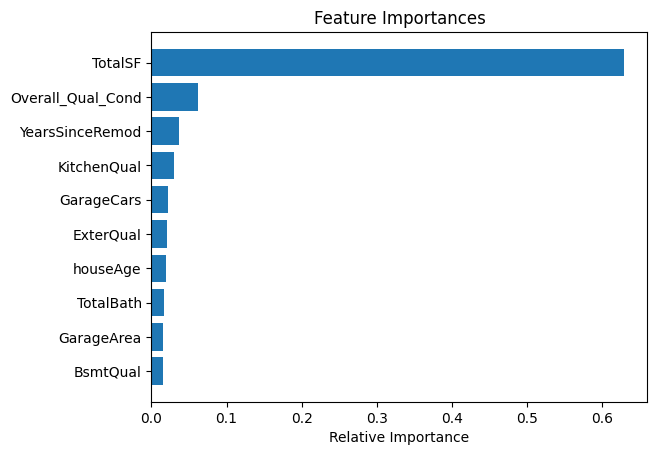

In [50]:
import matplotlib.pyplot as plt

# 获取 的特征重要性
features = X.columns
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-10:]  # 取前10

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [58]:
# Lasso 线性模型：对异常值敏感，所以加上 RobustScaler
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))

# XGBoost 梯度提升树：设置较小的学习率以防过拟合
model_xgb = xgb.XGBRegressor(colsample_bytree=0.46, gamma=0.04, 
                             learning_rate=0.05, max_depth=3, 
                             n_estimators=2200, reg_alpha=0.46, 
                             reg_lambda=0.85, subsample=0.52, 
                             random_state=7, nthread=-1)

# --- 4. 交叉验证评估 (RMSLE) ---


print(f"Lasso Score: {get_rmse(lasso).mean():.4f}")
print(f"XGBoost Score: {get_rmse(model_xgb).mean():.4f}")

Lasso Score: 0.1487
XGBoost Score: 0.1235


In [61]:
# 训练所有模型
lasso.fit(X_train, y_train)
model_xgb.fit(X_train, y_train)

## 交叉验证
lasso_cv_score = cross_val_score(lasso, X, y, cv=5).mean()
print(f"交叉验证准确率:{lasso_cv_score:4f}")


xbg_cv_score = cross_val_score(model_xgb, X, y, cv=5).mean()
print(f"交叉验证准确率:{xbg_cv_score:4f}")

# # 简单权重融合 (可以根据 CV 分数调整比例)
# def ensemble_predict(X):
#     return (0.4 * lasso.predict(X)) + (0.6 * model_xgb.predict(X))

# # y_pred_log = ensemble_predict(X_test)

# # # --- 4. 关键：指数反转 ---
# # # 因为训练时用了 log1p，预测结果必须用 expm1 还原成真实房价
# # final_price = np.expm1(y_pred_log)

交叉验证准确率:0.856537
交叉验证准确率:0.903622


# 预测

In [31]:
X_test = test_df[features]

In [32]:
y_pred_rf = np.expm1(rf_model.predict(X_test))
Submission_df = pd.DataFrame({"Id": test_df["Id"], "SalePrice":y_pred_rf})
Submission_df.to_csv("housepricing_submission3.csv", index=False)